In [14]:
!pip install -e ../TrackSelectorDNN/ TrackSelectorDNN &> /tmp/install.log

In [2]:
import torch
from TrackSelectorDNN.models.track_classifier import TrackClassifier
from TrackSelectorDNN.data_manager.dataset import TrackDatasetFromFile, collate_fn
from TrackSelectorDNN.tune.trainable import trainable
from torch.utils.data import DataLoader
import yaml
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ray import tune
from ray.air import RunConfig, CheckpointConfig
from TrackSelectorDNN.configs.schema import load_config

In [3]:
TRAIN_PATH = '/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/1000_tracks_train_dataset_extended.pt'
VAL_PATH   = '/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/1000_tracks_val_dataset_extended.pt'
PATH = '/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/205c3_00253/'
best_config_path = PATH + 'config.yaml'
best_ckpt_path = PATH + 'best_model.pt'
device ='cpu'

In [4]:
# Open and load YAML
best_config = load_config('top_grid.yaml')

train_ds = TrackDatasetFromFile(TRAIN_PATH)
val_ds   = TrackDatasetFromFile(VAL_PATH)

In [5]:
best_config

Config(model=ModelConfig(hit_input_dim=9, track_feat_dim=25, latent_dim=16, pooling_type='mean', netA_hidden_dim=64, netA_hidden_layers=2, netA_batchnorm=True, netA_activation='relu', netB_hidden_dim=32, netB_hidden_layers=3, netB_batchnorm=True, netB_activation='relu'), training=TrainingConfig(epochs=75, batch_size=128, patience=15, delta=0.0, base_checkpoint_directory='/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs', optimizer=OptimizerConfig(name='adam', lr=0.0017334529129498309, weight_decay=2.679880950553629e-05), scheduler=SchedulerConfig(name='none', min_lr=None, factor=None, patience=None, T_max=None, eta_min=None, max_lr=None, pct_start=None, anneal_strategy=None, div_factor=None, final_div_factor=None, three_phase=None), symmetry=SymmetryConfig(idxSymRecHitFeatures=[2, 7], idxSymRecoPixelTrackFeatures=[5, 7, 10, 22, 23], lambda_sym=2.0115041960831924e+16), weights=WeightsConfig(w_true=0.6, w_fake=2.91)), data=DataConfig(dataset_type='production', dummy_load_path=None, trai

In [6]:
best_config.training.base_checkpoint_directory

'/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs'

In [7]:
best_config.training.epochs    = 1
best_config.training.patience  = 160
best_config.training.symmetry.lambda_sym = None
best_config.training.base_checkpoint_directory = '/eos/user/e/ecoradin/GitHub/TrackSelectorDNN-Ray/final-run'
best_config.training.scheduler.name = "onecycle"
best_config.training.scheduler.max_lr = 0.002
best_config.training.scheduler.pct_start = 0.3
best_config.training.scheduler.anneal_strategy = 'cos'
best_config.training.scheduler.div_factor = 25
best_config.training.scheduler.final_div_factor = 1e4
best_config.training.scheduler.three_phase = False

best_config.data.train_path = TRAIN_PATH
best_config.data.val_path   = VAL_PATH

In [8]:
best_config

Config(model=ModelConfig(hit_input_dim=9, track_feat_dim=25, latent_dim=16, pooling_type='mean', netA_hidden_dim=64, netA_hidden_layers=2, netA_batchnorm=True, netA_activation='relu', netB_hidden_dim=32, netB_hidden_layers=3, netB_batchnorm=True, netB_activation='relu'), training=TrainingConfig(epochs=1, batch_size=128, patience=160, delta=0.0, base_checkpoint_directory='/eos/user/e/ecoradin/GitHub/TrackSelectorDNN-Ray/final-run', optimizer=OptimizerConfig(name='adam', lr=0.0017334529129498309, weight_decay=2.679880950553629e-05), scheduler=SchedulerConfig(name='onecycle', min_lr=None, factor=None, patience=None, T_max=None, eta_min=None, max_lr=0.002, pct_start=0.3, anneal_strategy='cos', div_factor=25, final_div_factor=10000.0, three_phase=False), symmetry=SymmetryConfig(idxSymRecHitFeatures=[2, 7], idxSymRecoPixelTrackFeatures=[5, 7, 10, 22, 23], lambda_sym=None), weights=WeightsConfig(w_true=0.6, w_fake=2.91)), data=DataConfig(dataset_type='production', dummy_load_path=None, train_

In [12]:
resources = {"cpu": 30, "gpu": 0}  # adjust if you want

ray_storage_path = "/shared/ray_final_results"

tuner = tune.Tuner(
    tune.with_resources(trainable, resources),
    param_space=best_config.model_dump(), 
    tune_config=tune.TuneConfig(num_samples=1), # Single final training run
    run_config=RunConfig(
        name="final_training_local",
        storage_path=ray_storage_path,
        checkpoint_config=CheckpointConfig(
            checkpoint_score_attribute="val_loss",
            num_to_keep=1,
        ),
        verbose=1
    )
)

results = tuner.fit()
best_result = results.get_best_result(metric="val_loss", mode="min")
best_ckpt = best_result.checkpoint

print("Final checkpoint stored at:")
best_ckpt

2025-12-12 13:13:39,505	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
2025-12-12 13:13:39,613	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/shared/ray_final_results/final_training_local' in 0.0241s.
2025-12-12 13:13:39,627	INFO tune.py:1041 -- Total run time: 126.31 seconds (126.25 seconds for the tuning loop).


Final checkpoint stored at:


Checkpoint(filesystem=local, path=/shared/ray_final_results/final_training_local/trainable_14ba7_00000_0_2025-12-12_13-11-33/checkpoint_000001)

In [34]:
!ls final-run/cb83a_00000

best_metrics.json  best_model.pt  config.yaml  metrics.csv  model.txt


In [9]:
final_ckpt = 'final-run/9231d_00000/best_model.pt'
FINAL_PATH = 'final-run/9231d_00000/'
val_loader = DataLoader(val_ds, batch_size=best_config.training.batch_size, collate_fn=collate_fn)
train_loader = DataLoader(train_ds, batch_size=best_config.training.batch_size, collate_fn=collate_fn)

In [10]:
model = TrackClassifier(**best_config.model.model_dump()).to(device)


model.load_state_dict(torch.load(final_ckpt, map_location=device))
model.eval()

TrackClassifier(
  (pool): MeanPooling()
  (netA): NetA(
    (mlp): Sequential(
      (0): Linear(in_features=9, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=16, bias=True)
    )
  )
  (netB): NetB(
    (mlp): Sequential(
      (0): Linear(in_features=41, out_features=32, bias=True)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=32, out_features=32, bias=True)
      (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=32, out_features=32, bias=True)
      (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True,

In [11]:
def plot_run_losses(run_dir):
    log_file = os.path.join(run_dir, "metrics.csv")  # or whatever CSVLogger writes
    if not os.path.exists(log_file):
        raise FileNotFoundError(f"No metrics.csv found in {run_dir}")

    df = pd.read_csv(log_file)

    # Assumes columns: epoch, train_loss, val_loss
    epochs = df["epoch"]
    train_loss = df["train_loss"]
    val_loss = df["val_loss"]

    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")

    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    #plt.yscale('log')
    #plt.xscale('log')
    plt.show()


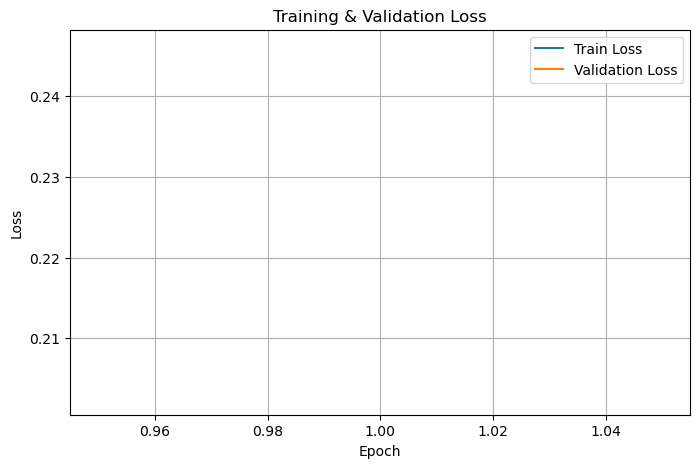

In [12]:
plot_run_losses(FINAL_PATH)

In [13]:
def predict(model, data_loader, device):
    all_preds = []

    with torch.no_grad():
        for batch in data_loader:
            hit_features = batch["hit_features"].to(device)
            track_features = batch["track_features"].to(device)
            mask = batch["mask"].to(device)
           
            preds = torch.sigmoid(model(hit_features, track_features, mask)).cpu().numpy()
            all_preds.append(preds)
    
        all_preds = np.concatenate(all_preds)
    return all_preds 

In [14]:
all_preds = predict(model, val_loader, device)
all_preds_train = predict(model, train_loader, device)

all_isHighPurity = val_ds.isHighPurity.numpy()  
all_labels = val_ds.labels.numpy()  
all_labels_train = train_ds.labels.numpy()  

In [15]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, ConfusionMatrixDisplay


In [16]:
# ROC curve
fpr_dnn, tpr_dnn, _ = roc_curve(all_labels, all_preds)
fpr_dnn_train, tpr_dnn_train, _ = roc_curve(all_labels_train, all_preds_train)

auc_dnn = auc(fpr_dnn, tpr_dnn)
auc_dnn_train = auc(fpr_dnn_train, tpr_dnn_train)

fpr_hp, tpr_hp, _ = roc_curve(all_labels, all_isHighPurity)
auc_hp = auc(fpr_hp, tpr_hp)

# Accuracy and confusion matrix for DNN
preds_bin = (all_preds > 0.09).astype(int)
acc_dnn = accuracy_score(all_labels, preds_bin)
tn, fp, fn, tp = confusion_matrix(all_labels, preds_bin, normalize='true').ravel()

print(f"✅ DNN Results:")
print(f"  AUC: {auc_dnn:.4f}")
print(f"  Accuracy: {acc_dnn:.4f}")
print(f"  True Positives:  {tp}")
print(f"  False Positives: {fp}")
print(f"  True Negatives:  {tn}")
print(f"  False Negatives: {fn}")

✅ DNN Results:
  AUC: 0.9751
  Accuracy: 0.9202
  True Positives:  0.990931005624777
  False Positives: 0.4119674185463659
  True Negatives:  0.5880325814536341
  False Negatives: 0.009068994375222975


In [17]:
# Accuracy for legacy classifier
acc_hp = accuracy_score(all_labels, all_isHighPurity)
tn_hp, fp_hp, fn_hp, tp_hp = confusion_matrix(all_labels, all_isHighPurity, normalize='true').ravel()

print(f"\n✅ Legacy (isHighPurity) Results:")
print(f"  AUC: {auc_hp:.4f}")
print(f"  Accuracy: {acc_hp:.4f}")
print(f"  True Positives:  {tp_hp}")
print(f"  False Positives: {fp_hp}")
print(f"  True Negatives:  {tn_hp}")
print(f"  False Negatives: {fn_hp}")


✅ Legacy (isHighPurity) Results:
  AUC: 0.6525
  Accuracy: 0.8684
  True Positives:  0.9852195396818517
  False Positives: 0.6801535087719298
  True Negatives:  0.3198464912280702
  False Negatives: 0.014780460318148324


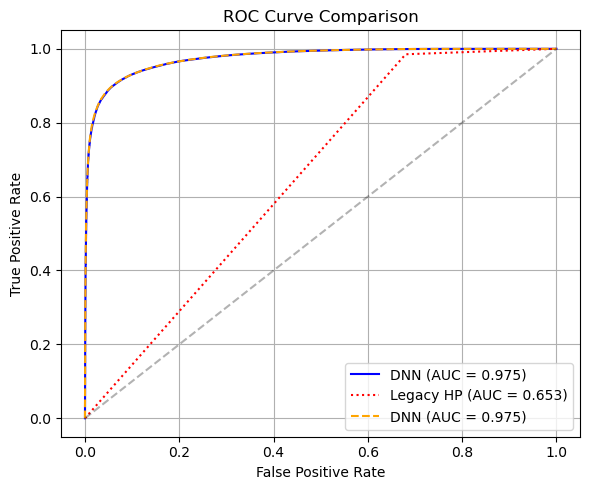

In [18]:
plt.figure(figsize=(6, 5))
plt.plot(fpr_dnn, tpr_dnn, label=f"DNN (AUC = {auc_dnn:.3f})", color='blue')
plt.plot(fpr_hp, tpr_hp, label=f"Legacy HP (AUC = {auc_hp:.3f})", linestyle="dotted", color='red')
plt.plot(fpr_dnn_train, tpr_dnn_train, label=f"DNN (AUC = {auc_dnn_train:.3f})", linestyle="--", color='orange')
plt.plot([0, 1], [0, 1], "k--", alpha=0.3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

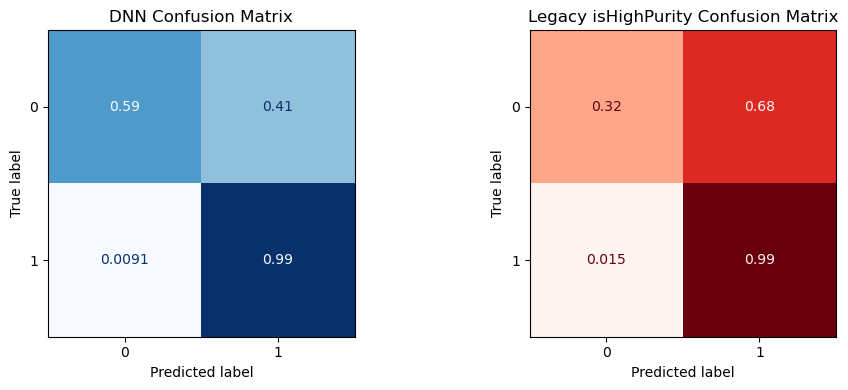

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay(confusion_matrix(all_labels, preds_bin, normalize='true')).plot(
    ax=axes[0], cmap="Blues", colorbar=False
)
axes[0].set_title("DNN Confusion Matrix")

ConfusionMatrixDisplay(confusion_matrix(all_labels, all_isHighPurity, normalize='true')).plot(
    ax=axes[1], cmap="Reds", colorbar=False
)
axes[1].set_title("Legacy isHighPurity Confusion Matrix")

for ax in axes:
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

plt.tight_layout()
plt.show()

In [49]:
scores = all_preds.flatten()
labels = all_labels.astype(int)

thresholds = np.linspace(0, 1, 200)

tpr_list = []   # P(pred=1 | true=1)
tnr_list = []   # P(pred=0 | true=0)

for t in thresholds:
    preds_bin = (scores > t).astype(int)

    # mask for classes
    mask0 = (labels == 0)
    mask1 = (labels == 1)

    # TPR
    if mask1.sum() > 0:
        tpr = preds_bin[mask1].mean()
    else:
        tpr = np.nan

    # TNR = P(pred=0 | true=0)
    if mask0.sum() > 0:
        tnr = (1 - preds_bin[mask0]).mean()
    else:
        tnr = np.nan

    tpr_list.append(tpr)
    tnr_list.append(tnr)

tpr_list = np.array(tpr_list)
tnr_list = np.array(tnr_list)

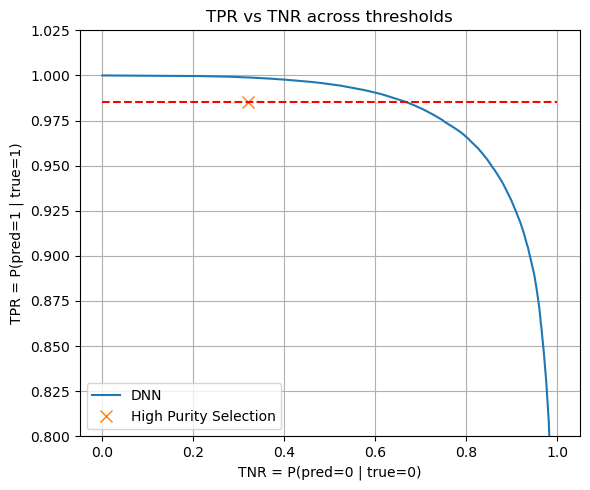

In [50]:
plt.figure(figsize=(6,5))
plt.plot(tnr_list, tpr_list, '-', label='DNN')
plt.plot(tn_hp, tp_hp, 'x', markersize=8, label='High Purity Selection')
plt.xlabel("TNR = P(pred=0 | true=0)")
plt.ylabel("TPR = P(pred=1 | true=1)")
plt.title("TPR vs TNR across thresholds")
plt.hlines(tp_hp,0,1,'red', 'dashed')
plt.grid(True)
plt.ylim(0.8, 1.025)
plt.tight_layout()
plt.legend(loc='lower left')
plt.show()

In [51]:
# indices where TPR >= required TPR
idx = np.where(tpr_list >= tp_hp)[0]

if len(idx) == 0:
    print("No threshold reaches the required TPR!")
else:
    # choose the *last* threshold that satisfies it (closest above tp_hp)
    best_idx = idx[-1]
    best_threshold = thresholds[best_idx]
    best_tpr = tpr_list[best_idx]
    best_tnr = tnr_list[best_idx]

    print("Threshold:", best_threshold)
    print("TPR:", best_tpr)
    print("TNR:", best_tnr)

Threshold: 0.10050251256281408
TPR: 0.9858563698015824
TNR: 0.6599937343358396


In [ ]:
# Load previously exported binning
binning = np.loadtxt("/eos/user/e/ecoradin/sakura/examples/results/binning_fakeVsEta.txt", comments="#")

# Extract only the bin edges for compute_fake_rate
eta_bins = np.unique(np.concatenate([binning[:,0], binning[:,1]]))
eta_centers = 0.5 * (eta_bins[:-1] + eta_bins[1:])
external_fake = binning[:,2]
print("Loaded η bins")

In [ ]:
from scipy.stats import binomtest

In [ ]:
def compute_fake_rate(y_true, y_pred_bin, eta, bins, cl=0.683):
    nbins = len(bins) - 1
    fake_rate = np.full(nbins, np.nan)
    fake_err_low = np.full(nbins, np.nan)
    fake_err_up  = np.full(nbins, np.nan)

    for i in range(nbins):
        sel = (eta >= bins[i]) & (eta < bins[i+1])
        if sel.sum() == 0:
            continue

        predicted_real = (y_pred_bin[sel] == 1)
        #print(predicted_real.shape, predicted_real.sum(), y_true[sel].sum())
        total = predicted_real.sum()
        if total == 0:
            continue

        fake = ((y_true[sel] == 0) & predicted_real).sum()

        # central value
        p = fake / total
        fake_rate[i] = p

        # binomial confidence interval
        result = binomtest(fake, total)
        ci = result.proportion_ci(confidence_level=cl)

        fake_err_low[i] = p - ci.low
        fake_err_up[i]  = ci.high - p
    
    return fake_rate, fake_err_low, fake_err_up

def compute_efficiency(y_true, y_pred_bin, eta, bins, cl=0.683):
    nbins = len(bins) - 1
    eff = np.full(nbins, np.nan)
    eff_err_low = np.full(nbins, np.nan)
    eff_err_up  = np.full(nbins, np.nan)

    for i in range(nbins):
        sel = (eta >= bins[i]) & (eta < bins[i+1])

        true_sel = sel & (y_true == 1)
        total = true_sel.sum()
        if total == 0:
            continue

        passed = (y_pred_bin[true_sel] == 1).sum()

        # central value
        p = passed / total
        eff[i] = p

        # binomial confidence interval
        result = binomtest(passed, total)
        ci = result.proportion_ci(confidence_level=cl)

        eff_err_low[i] = p - ci.low
        eff_err_up[i]  = ci.high - p

    return eff, eff_err_low, eff_err_up

# --- Recover raw η ---
eta_idx = val_ds.recoPixelTrackBranches.index("hltPixelTrack_eta")

eta_norm = val_ds.recoPixelTrackFeatures[:, eta_idx].numpy()
eta_mean = val_ds.recoPixelTrack_mean[0, eta_idx].numpy()
eta_std  = val_ds.recoPixelTrack_std[0, eta_idx].numpy()

eta_vals = eta_norm * eta_std + eta_mean   # <-- raw η

# --- Threshold predictions ---
preds_bin = (all_preds > 0.06).astype(int)
labels = all_labels.astype(int)
hp = all_isHighPurity.astype(int)

# --- Binomial CI fake rates ---
print('---- DNN ') 
fake_rate_dnn, fake_low_dnn, fake_up_dnn = compute_fake_rate(labels, preds_bin, eta_vals, eta_bins)
print('---- HP ')
fake_rate_hp,  fake_low_hp,  fake_up_hp  = compute_fake_rate(labels, hp,       eta_vals, eta_bins)
print('---- Worst ')
fake_rate_worst,  fake_low_worst,  fake_up_worst  = compute_fake_rate(labels, np.ones_like(labels),       eta_vals, eta_bins)

# --- Binomial CI efficiency ---
eff_dnn, eff_low_dnn, eff_up_dnn = compute_efficiency(labels, preds_bin, eta_vals, eta_bins)
eff_hp,  eff_low_hp,  eff_up_hp  = compute_efficiency(labels, hp,       eta_vals, eta_bins)


In [ ]:
# --- Plot Fake Rate ---
plt.figure(figsize=(7,5))
plt.errorbar(
    eta_centers, fake_rate_dnn,
    yerr=[fake_low_dnn, fake_up_dnn],
    fmt='o-', label='DNN', alpha=0.8, color='blue',
)

plt.errorbar(
    eta_centers, fake_rate_hp,
    yerr=[fake_low_hp, fake_up_hp],
    fmt='s--', label='High Purity Selection', alpha=0.8, color = 'red'
)
#plt.errorbar(
#    eta_centers, fake_rate_worst,
#    yerr=[fake_low_worst, fake_up_worst],
#    fmt='s--', label='Worst classifier', alpha=0.8
#)
#plt.plot(eta_centers, external_fake)
plt.xlabel('Track η')
plt.ylabel('Fake Rate')
plt.title('Fake Rate vs η')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(0,0.4)
plt.tight_layout()
plt.show()

In [ ]:
# --- Plot Efficiency ---
plt.figure(figsize=(7,5))
plt.errorbar(
    eta_centers, eff_dnn,
    yerr=[eff_low_dnn, eff_up_dnn],
    fmt='o-', label='DNN', color='blue', alpha=0.8
)

plt.errorbar(
    eta_centers, eff_hp,
    yerr=[eff_low_hp, eff_up_hp],
    fmt='o-', label='High Purity', color='red', alpha=0.8
)
plt.xlabel('Track η')
plt.ylabel('Efficiency')
plt.title('True-Track Efficiency vs η')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(0.90, 1.05)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

tn_hp, fp_hp, fn_hp, tp_hp = confusion_matrix(all_labels, hp).ravel()
tpr_hp = tp_hp / (tp_hp + fn_hp)

print("Legacy TPR:", tpr_hp)
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
idx = np.argmin(np.abs(tpr - tpr_hp))

best_threshold = thresholds[idx]
tpr_dnn_at_best = tpr[idx]
fpr_dnn_at_best = fpr[idx]

print("Best DNN threshold:", best_threshold)
print("DNN TPR at matched point:", tpr_dnn_at_best)
print("DNN FPR at matched point:", fpr_dnn_at_best)

In [ ]:
ratio = np.array(eff_dnn)/np.array(eff_hp)
np.nanmin(ratio), np.nanmax(ratio)

Prepare the model for inference in cmssw

In [ ]:
from TrackSelectorDNN.models.preprocessing import FeaturePreprocessing
from TrackSelectorDNN.models.track_classifier import TrackClassifierInference  
import onnxruntime as ort
import onnx

In [ ]:
pre_hit = FeaturePreprocessing(mean=train_ds.recHit_mean, std=train_ds.recHit_std, 
                                 clip_min=train_ds.clip_min_hit[0], clip_max=train_ds.clip_max_hit[0],
                                 do_log=train_ds.do_log_hit[0]
                              )

pre_track = FeaturePreprocessing(mean=train_ds.recoPixelTrack_mean, std=train_ds.recoPixelTrack_std, 
                                 clip_min=train_ds.clip_min_track[0], clip_max=train_ds.clip_max_track[0],
                                 do_log=train_ds.do_log_track[0])

In [ ]:
model_inf = TrackClassifierInference(model, pre_hit, pre_track)
model_inf.eval()

In [ ]:
dummy_hits   = torch.zeros(128, train_ds.MAX_HITS, best_config["hit_input_dim"])
dummy_tracks = torch.zeros(128, best_config["track_feat_dim"])

torch.onnx.export(
    model_inf,
    (dummy_hits, dummy_tracks),
    "track_classifier_final_training.onnx",
    input_names=["hits", "tracks"],
    output_names=["probabilities"],
    dynamic_axes={
        "hits": {0: "batch", 1: "nhits"},
        "tracks": {0: "batch"},
        "probabilities": {0: "batch"},
    },
    opset_version=17
)

In [ ]:
onnx_model = onnx.load("track_classifier_final_training.onnx")
onnx.checker.check_model(onnx_model)

In [ ]:
sess_options = ort.SessionOptions()
sess_options.intra_op_num_threads = 1  # or any number of threads you want
sess_options.inter_op_num_threads = 1

ort_session = ort.InferenceSession("track_classifier_final_training.onnx", sess_options)

def predict_onnx(ort_session, data_loader, device):
    all_preds = []

    for batch in data_loader:
        hit_features = batch["hit_features"].cpu().numpy()  # ONNX expects numpy
        track_features = batch["track_features"].cpu().numpy()
        
        ort_inputs = {
            "hits": hit_features,
            "tracks": track_features
        }
        preds = ort_session.run(None, ort_inputs)[0]  # list -> array
        all_preds.append(preds)
    
    return np.concatenate(all_preds)

In [ ]:
def predict_inference(model, data_loader, device):
    all_preds = []

    with torch.no_grad():
        for batch in data_loader:
            hit_features = batch["hit_features"].to(device)
            track_features = batch["track_features"].to(device)
           
            preds = model(hit_features, track_features).cpu().numpy()
            all_preds.append(preds)
    
        all_preds = np.concatenate(all_preds)
    return all_preds 

In [ ]:
base_path = '/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/'
train_ds = TrackDatasetFromFile(base_path+'tracks_train_dataset_inference.pt')
val_ds   = TrackDatasetFromFile(base_path+'tracks_val_dataset_inference.pt')

val_loader = DataLoader(val_ds, batch_size=best_config["batch_size"], collate_fn=collate_fn)
train_loader = DataLoader(train_ds, batch_size=best_config["batch_size"], collate_fn=collate_fn)

In [ ]:
train_ds.recHit_mean, train_ds.recHit_std, train_ds.clip_min_hit[0][0],train_ds.clip_max_hit[0][0],train_ds.do_log_hit[0][0]

In [ ]:
train_ds.recoPixelTrack_mean, train_ds.recoPixelTrack_std,train_ds.clip_min_track[0][0], train_ds.clip_max_track[0][0],
train_ds.do_log_track[0][0]

In [ ]:
train_ds.recHit_mean, train_ds.recHit_std, train_ds.clip_min_hit[0],train_ds.clip_max_hit[0],train_ds.do_log_hit[0]

In [ ]:
train_ds.recoPixelTrack_mean, train_ds.recoPixelTrack_std,train_ds.clip_min_track[0], train_ds.clip_max_track[0],
train_ds.do_log_track[0]

In [ ]:
all_preds = predict_inference(model_inf, val_loader, device)
all_preds_train = predict_inference(model_inf, train_loader, device)

onnx_preds_val = predict_onnx(ort_session, val_loader, device)
onnx_preds_train = predict_onnx(ort_session, train_loader, device)


all_isHighPurity = val_ds.isHighPurity.numpy()  
all_labels = val_ds.labels.numpy()  
all_labels_train = train_ds.labels.numpy()  

In [ ]:
# Compute max difference
max_diff_val = np.max(np.abs(all_preds - onnx_preds_val))
max_diff_train = np.max(np.abs(all_preds_train - onnx_preds_train))

print("Max diff (val):", max_diff_val)
print("Max diff (train):", max_diff_train)

In [ ]:
corr_val = np.corrcoef(all_preds.flatten(), onnx_preds_val.flatten())[0,1]
corr_train = np.corrcoef(all_preds_train.flatten(), onnx_preds_train.flatten())[0,1]

print("Correlation val:", corr_val)
print("Correlation train:", corr_train)